<a href="https://colab.research.google.com/github/bi-horn/CNN_Medical_Image_Classification/blob/main/CNN_XRay.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torchvision
print(torchvision.__version__)

0.16.0+cu121


In [1]:
#Mount Google Drive
from google.colab import drive
drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, time, random, torch, warnings
import numpy as np
from PIL import Image
import torch.nn as nn
from tqdm import tqdm
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import precision_score, recall_score, f1_score

warnings.simplefilter("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

Defining functions

Starting with model

In [7]:
data_path = '/content/drive/My Drive/XRay/'

sample_ratio = 0.4
batch_size = 64 #smaller size to ensure better convergence
num_epochs = 20 #if computational cost would not matter, good practice would be to observe when the model does not get any better

In [8]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

In [9]:
#load training, test and validation datasets and preprocess the images
%run '/content/drive/My Drive/Colab Notebooks/utils.ipynb'
dataset, train_loader, train_indices, test_loader, test_indices, val_loader, val_indices = data_preprocess(data_path, sample_ratio)

Dataset ImageFolder
    Number of datapoints: 5855
    Root location: /content/drive/My Drive/XRay/data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=warn)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
           )


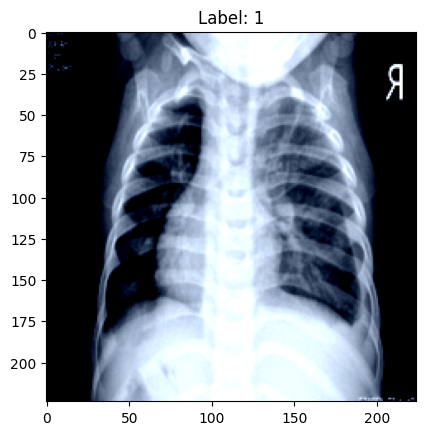

In [ ]:
#View the dataset and print a XRay image to see if everything is correctly resized and transformed

print(dataset)

#Grab 1 image
# Get one batch of data from the train loader
for images, labels in train_loader:
    break  # Exit the loop after the first batch

# Convert Tensor to numpy array
image = images[0].numpy()
label = labels[0].item()

# Denormalize the image (if normalization was applied)
# Use the inverse of the normalization transform, e.g. if you used transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
# you can denormalize by multiplying by 0.5 and then adding 0.5
image = image * 0.485 + 0.229

# Display the image
plt.imshow(np.transpose(image, (1, 2, 0)))
plt.title(f'Label: {label}')
plt.show()

In [10]:
# Define the ResNet34 model and set Pretraining to False to train model from scratch
# ResNet50 or higher is even deeper and might aim better results but it is a balance between model complexity and computational cost

model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes)) #replaces the fully connected layer (model.fc) with a new one that has the output size matching the number of classes in the dataset
#print(len(dataset.classes)) #= 2 NORMAL or PNEUMONIA
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

#criterion and optimizer are inputs of the train function
model_name = "ResNet34"
losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, model_name, num_epochs)

#Save pre-trained model to file
torch.save(model.state_dict(), "{}{}.pth".format(data_path, model_name))



Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0
Epoch 1/20: 100%|██████████| 26/26 [16:39<00:00, 38.46s/batch,        Accuracy=0.846, Loss=0.666, Precision=0.816, Recall=0.804, F1 Score=0.809]


VALIDATION: Accuracy: 0.7532 | Loss: 1.6236 | Recall: 0.5000 | Precision: 0.3766 | F-score: 0.4296



Epoch 2/20: 100%|██████████| 26/26 [15:51<00:00, 36.60s/batch,        Accuracy=0.696, Loss=1.01, Precision=0.723, Recall=0.686, F1 Score=0.699]


VALIDATION: Accuracy: 0.7745 | Loss: 0.4590 | Recall: 0.5431 | Precision: 0.8848 | F-score: 0.5143



Epoch 3/20: 100%|██████████| 26/26 [14:11<00:00, 32.76s/batch,        Accuracy=0.816, Loss=0.738, Precision=0.743, Recall=0.711, F1 Score=0.723]


VALIDATION: Accuracy: 0.8298 | Loss: 0.4481 | Recall: 0.8812 | Precision: 0.7933 | F-score: 0.8068



Epoch 4/20: 100%|██████████| 26/26 [14:28<00:00, 33.40s/batch,        Accuracy=0.877, Loss=0.92, Precision=0.771, Recall=0.746, F1 Score=0.757]


VALIDATION: Accuracy: 0.8979 | Loss: 0.2184 | Recall: 0.8858 | Precision: 0.8551 | F-score: 0.8685



Epoch 5/20: 100%|██████████| 26/26 [14:22<00:00, 33.16s/batch,        Accuracy=0.916, Loss=0.572, Precision=0.798, Recall=0.777, F1 Score=0.786]


VALIDATION: Accuracy: 0.9106 | Loss: 0.2037 | Recall: 0.9175 | Precision: 0.8681 | F-score: 0.8878



Epoch 6/20: 100%|██████████| 26/26 [14:35<00:00, 33.66s/batch,        Accuracy=0.923, Loss=0.434, Precision=0.817, Recall=0.798, F1 Score=0.807]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1893 | Recall: 0.9344 | Precision: 0.9036 | F-score: 0.9174



Epoch 7/20: 100%|██████████| 26/26 [14:29<00:00, 33.44s/batch,        Accuracy=0.933, Loss=0.408, Precision=0.833, Recall=0.815, F1 Score=0.823]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1715 | Recall: 0.9083 | Precision: 0.9288 | F-score: 0.9179



Epoch 8/20: 100%|██████████| 26/26 [14:29<00:00, 33.44s/batch,        Accuracy=0.917, Loss=0.661, Precision=0.842, Recall=0.825, F1 Score=0.832]


VALIDATION: Accuracy: 0.9277 | Loss: 0.1912 | Recall: 0.8824 | Precision: 0.9184 | F-score: 0.8985



Epoch 9/20: 100%|██████████| 26/26 [14:13<00:00, 32.84s/batch,        Accuracy=0.94, Loss=0.544, Precision=0.851, Recall=0.836, F1 Score=0.843]


VALIDATION: Accuracy: 0.9319 | Loss: 0.1912 | Recall: 0.9258 | Precision: 0.8994 | F-score: 0.9114



Epoch 10/20: 100%|██████████| 26/26 [14:14<00:00, 32.88s/batch,        Accuracy=0.954, Loss=0.284, Precision=0.861, Recall=0.846, F1 Score=0.853]


VALIDATION: Accuracy: 0.9277 | Loss: 0.1987 | Recall: 0.9346 | Precision: 0.8895 | F-score: 0.9083



Epoch 11/20: 100%|██████████| 26/26 [15:01<00:00, 34.68s/batch,        Accuracy=0.946, Loss=0.449, Precision=0.868, Recall=0.854, F1 Score=0.861]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1679 | Recall: 0.9344 | Precision: 0.9036 | F-score: 0.9174



Epoch 12/20: 100%|██████████| 26/26 [14:37<00:00, 33.76s/batch,        Accuracy=0.952, Loss=0.355, Precision=0.875, Recall=0.861, F1 Score=0.867]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1422 | Recall: 0.9141 | Precision: 0.9241 | F-score: 0.9189



Epoch 13/20: 100%|██████████| 26/26 [14:22<00:00, 33.16s/batch,        Accuracy=0.954, Loss=0.0884, Precision=0.88, Recall=0.867, F1 Score=0.873]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1692 | Recall: 0.9344 | Precision: 0.9036 | F-score: 0.9174



Epoch 14/20: 100%|██████████| 26/26 [14:34<00:00, 33.64s/batch,        Accuracy=0.969, Loss=0.067, Precision=0.887, Recall=0.874, F1 Score=0.88]


VALIDATION: Accuracy: 0.8681 | Loss: 0.3011 | Recall: 0.9008 | Precision: 0.8227 | F-score: 0.8442



Epoch 15/20: 100%|██████████| 26/26 [14:23<00:00, 33.20s/batch,        Accuracy=0.952, Loss=0.703, Precision=0.89, Recall=0.879, F1 Score=0.884]


VALIDATION: Accuracy: 0.9404 | Loss: 0.1289 | Recall: 0.9141 | Precision: 0.9241 | F-score: 0.9189



Epoch 16/20: 100%|██████████| 26/26 [14:14<00:00, 32.87s/batch,        Accuracy=0.973, Loss=0.413, Precision=0.895, Recall=0.884, F1 Score=0.889]


VALIDATION: Accuracy: 0.9319 | Loss: 0.2303 | Recall: 0.8737 | Precision: 0.9412 | F-score: 0.9012



Epoch 17/20: 100%|██████████| 26/26 [14:20<00:00, 33.09s/batch,        Accuracy=0.968, Loss=0.168, Precision=0.899, Recall=0.888, F1 Score=0.894]


VALIDATION: Accuracy: 0.9489 | Loss: 0.1467 | Recall: 0.9371 | Precision: 0.9274 | F-score: 0.9321



Epoch 18/20: 100%|██████████| 26/26 [14:28<00:00, 33.40s/batch,        Accuracy=0.984, Loss=0.0757, Precision=0.904, Recall=0.893, F1 Score=0.898]


VALIDATION: Accuracy: 0.9447 | Loss: 0.1714 | Recall: 0.9169 | Precision: 0.9323 | F-score: 0.9243



Epoch 19/20: 100%|██████████| 26/26 [14:23<00:00, 33.23s/batch,        Accuracy=0.982, Loss=0.902, Precision=0.908, Recall=0.898, F1 Score=0.903]


VALIDATION: Accuracy: 0.9532 | Loss: 0.1490 | Recall: 0.9457 | Precision: 0.9311 | F-score: 0.9381



Epoch 20/20: 100%|██████████| 26/26 [14:10<00:00, 32.73s/batch,        Accuracy=0.979, Loss=0.0831, Precision=0.912, Recall=0.901, F1 Score=0.906]


VALIDATION: Accuracy: 0.9362 | Loss: 0.1928 | Recall: 0.9460 | Precision: 0.8998 | F-score: 0.9191

Training took: 307.4788579742114 minutes


In [ ]:
#Version 2:
model = ConvolutionalNetwork()
model.to(device)

# Define loss function as CrossEntropy and optimizer as Adam Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, "Simple_model", num_epochs)

Epoch 1/2: 100%|██████████| 18/18 [02:10<00:00,  7.25s/batch, Accuracy=0.719, Loss=0.0716, Precision=0.639, Recall=0.559, F1 Score=0.548]


VALIDATION: Accuracy: 0.8638 | Loss: 0.3445 | Recall: 0.7415 | Precision: 0.8817 | F-score: 0.7801



Epoch 2/2: 100%|██████████| 18/18 [01:12<00:00,  4.04s/batch, Accuracy=0.879, Loss=0.0764, Precision=0.792, Recall=0.687, F1 Score=0.709]


VALIDATION: Accuracy: 0.8809 | Loss: 0.2743 | Recall: 0.8803 | Precision: 0.8327 | F-score: 0.8511



 ## Load the saved model

In [ ]:
model_name = "ResNet34"
model = torch.hub.load('pytorch/vision:v0.9.0', 'resnet34', pretrained = False)
model.fc = nn.Linear(512, len(dataset.classes))
#or
#model = ConvolutionalNeuralNetwork()
model.to(device)

model.load_state_dict(torch.load("{}{}_trained.pth".format(data_path, model_name)))

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.9.0


<All keys matched successfully>

In [ ]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
# Load the saved model parameters
# Assuming 'data_path' contains the path to your model
#model_path = "{}resnet18.pth".format(data_path)

def load_metrics(model_name, data_path):
  train_loss = np.load("{}{}_train_loss.npy".format(data_path, model_name))
  train_accuracy = np.load("{}{}_train_accuracy.npy".format(data_path, model_name))
  val_loss = np.load("{}{}_validation_loss.npy".format(data_path, model_name))
  val_accuracy = np.load("{}{}_validation_accuracy.npy".format(data_path, model_name))
  return train_loss, train_accuracy, val_loss, val_accuracy


losses, accuracies, v_losses, v_accuracies = load_metrics(model_name, data_path)

print(losses)
print(accuracies)

[2.15000611e-04 3.22643306e-03 8.50279768e-04 1.30544463e-04
 2.45452058e-03 8.68029270e-04 2.35561993e-04 4.45518345e-04
 1.45583268e-03 1.16101741e-04 1.57275751e-04 1.39015089e-03
 1.70386150e-03 5.58765915e-04 2.61074686e-04 5.68155286e-05
 7.77644065e-05 1.63132529e-05 1.76966440e-04 4.34977027e-05]
[0.86455156 0.7071385  0.74679683 0.89688835 0.90115924 0.91214155
 0.91458206 0.91397193 0.9371568  0.92495424 0.94691885 0.95607077
 0.92312386 0.93776693 0.9652227  0.9609518  0.95118975 0.97437462
 0.976205   0.96949359]


In [14]:
%run '/content/drive/My Drive/Colab Notebooks/utils.ipynb'

##Plot the Model Accuracy and Loss on Training and Validation Sets

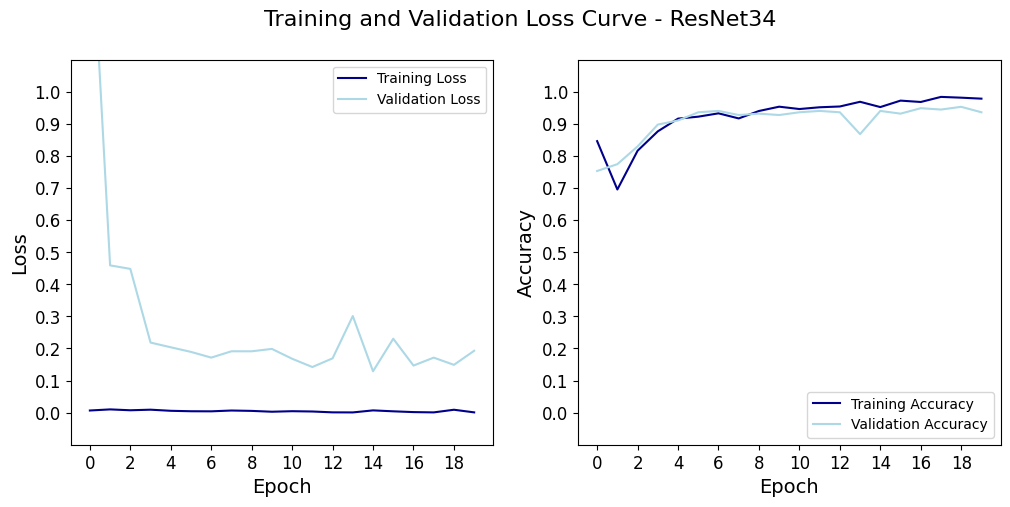

In [15]:
model_name = "ResNet34"
plot_model_curves(losses, accuracies, v_accuracies, v_losses, data_path, model_name)


##Plot the Confusion Matrix on Test Set

TEST: Accuracy: 0.9444 | Loss: 0.1603 | Recall: 0.9567 | Precision: 0.9189 | F-score: 0.9345



<Figure size 800x800 with 0 Axes>

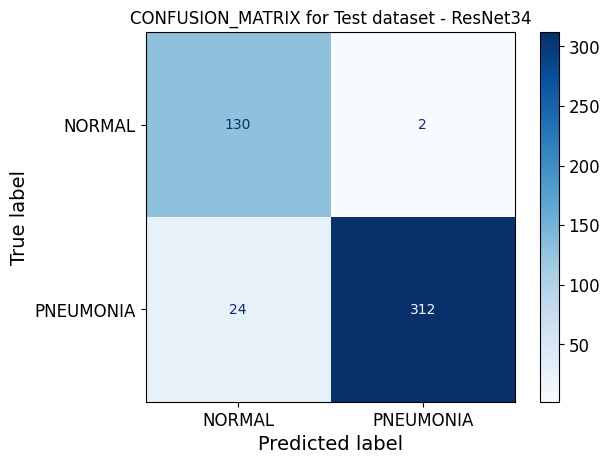

In [16]:
test_accuracy, test_loss, test_true, test_pred = evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, model_name)

plot_confusion_mat(test_true, test_pred, model_name, test_loader, "Test", data_path)

##Plot the Receiver-Operating Curve (ROC) for detecting pneumonia versus normal

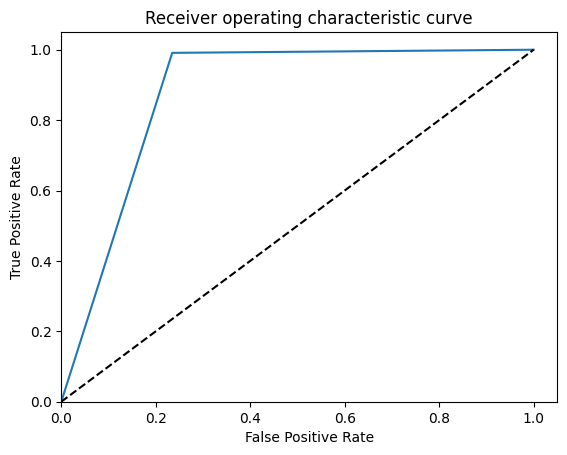

0.8781114718614719

In [ ]:
generate_roc(test_true, test_pred, data_path, model_name, pos_label = 1)

##Hyperparameter tuning (here learning rate tuning)

In [ ]:

model_name = "ResNet18"
#or
#model_name = "SimpleModel"

learning_rate = [0.005, 0.0001, 0.0005, 0.00001]

for i in learning_rate:

  if model_name == "ResNet18":
        model = models.resnet18(pretrained=False)
        model.fc = nn.Linear(512, len(dataset.classes))
  elif model_name == "SimpleModel":
        model = ConvolutionalNetwork()  # Assuming ConvolutionalNetwork is defined elsewhere
  else:
        print("Error: Unknown model name")

  model.to(device)  # Assuming device is defined earlier

  print("Training Model {} with Learning Rate = {}, Batch Size = {}, Number of Epochs = {}".format(learning_rate.index(i)+1, i, batch_size, num_epochs))
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(model.parameters(), lr = i)

  losses, accuracies, v_accuracies, v_losses = train_model(model, criterion, optimizer, model_name, num_epochs)
  #Save Model
  torch.save(model.state_dict(), "{}{}_{}.pth". format(data_path, i, model_name))
  #Plotting the Loss and Accuracy Curves
  plot_model_curves(losses, accuracies, v_accuracies, v_losses)
  #Evaluate Model on Test Set
  evaluate_model(model, test_loader, test_indices, 'TEST', criterion, data_path, model_name)


Training Model 1 with Learning Rate = 0.005, Batch Size = 50, Number of Epochs = 10


Epoch 1/10: 100%|██████████| 8/8 [00:10<00:00,  1.35s/batch, Accuracy=0.508, Loss=7.76, Precision=0.514, Recall=0.513, F1 Score=0.506]


VALIDATION: Accuracy: 0.4286 | Loss: 0.7044 | Recall: 0.4026 | Precision: 0.3021 | F-score: 0.3243



Epoch 2/10:   0%|          | 0/8 [00:03<?, ?batch/s]


KeyboardInterrupt: 